<a href="https://colab.research.google.com/github/pren1/VAST/blob/master/Splitter_playground_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# %tensorflow_version 1.x

In [0]:
!rm -rf VAST/
!git clone https://github.com/pren1/VAST.git
!pip3 install soundfile
!pip3 install librosa

Cloning into 'VAST'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 171 (delta 81), reused 70 (delta 26), pack-reused 0
Receiving objects: 100% (171/171), 53.56 MiB | 9.62 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [0]:
from VAST.util import *
import pdb
import pprint
from tqdm import tqdm
import numpy as np
import IPython
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import os
from tqdm import trange

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# adapted from Keith Ito's tacotron implementation
# https://github.com/keithito/tacotron/blob/master/util/audio.py

import librosa
import numpy as np


class Audio():
    def __init__(self):
        self.ref_level_db = 20.0
        self.n_fft = 1200
        self.hop_length = 160
        self.win_length = 400
        self.min_level_db = -100.0

    def wav2spec(self, y):
        D = self.stft(y)
        S = self.amp_to_db(np.abs(D)) - self.ref_level_db
        S, D = self.normalize(S), np.angle(D)
        S, D = S.T, D.T # to make [time, freq]
        return S, D

    def spec2wav(self, spectrogram, phase):
        spectrogram, phase = spectrogram.T, phase.T
        # used during inference only
        # spectrogram: enhanced output
        # phase: use noisy input's phase, so no GLA is required
        S = self.db_to_amp(self.denormalize(spectrogram) + self.ref_level_db)
        return self.istft(S, phase)

    def stft(self, y):
        return librosa.stft(y=y, n_fft=self.n_fft,
                            hop_length=self.hop_length,
                            win_length=self.win_length)

    def istft(self, mag, phase):
        stft_matrix = mag * np.exp(1j*phase)
        return librosa.istft(stft_matrix,
                             hop_length=self.hop_length,
                             win_length=self.win_length)

    def amp_to_db(self, x):
        return 20.0 * np.log10(np.maximum(1e-5, x))

    def db_to_amp(self, x):
        return np.power(10.0, x * 0.05)

    def normalize(self, S):
        return np.clip(S / -self.min_level_db, -1.0, 0.0) + 1.0

    def denormalize(self, S):
        return (np.clip(S, 0.0, 1.0) - 1.0) * -self.min_level_db

audio = Audio()

In [0]:
embedding_matrix = np.asarray([
         [-0.8265083 , -1.6049656 ,  1.5085448 ,  0.6589694 ,  2.1224942 ,
         2.3647609 ,  0.11735925,  1.1543381 ,  0.99229884,  1.4278704 ,
         0.5712279 , -1.5206277 ,  0.30854183, -2.6490169 ,  1.3902934 ,
        -0.23975304,  0.94975144, -2.0093975 ,  0.17497058, -1.0554106 ,
        -2.172874  , -1.5222347 ,  0.563387  ,  2.239781  , -0.96120906,
        -0.42689592,  2.4739625 , -2.362247  , -0.98188835,  0.16969077,
        -0.6247616 ,  0.04511972],
        [ 0.47638106,  1.8903663 , -2.9872196 ,  2.3670852 , -2.4623342 ,
         2.220159  ,  0.23939389,  1.5010741 , -0.7784126 , -0.54998654,
        -2.0378437 , -0.07159348,  0.3601075 ,  1.7380389 ,  2.3474126 ,
        -1.0004979 ,  0.47312295, -0.88486624,  0.18921344, -0.43055353,
         0.38867134,  0.00616272, -3.2682106 , -2.6373188 ,  2.909382  ,
         0.7305331 , -1.1071701 ,  0.9580342 , -1.1098799 , -1.7031851 ,
         0.00362744,  2.3521018 ]
         ])

In [0]:
embedding_matrix.shape

(2, 32)

In [0]:
import math
import tensorflow as tf

def trunk_network(conv_size = 64, LSTM_size = 400, input_size = (151, 601), dropout_rate = 0.4):
    inputs = tf.keras.layers.Input(input_size)

    speaker_embeddings = tf.keras.Input(shape=(1, 32), dtype=tf.float32)
    
    x = tf.keras.layers.Reshape((input_size[0],  input_size[1], 1))(inputs)
    # cnn1
    x = tf.keras.layers.ZeroPadding2D(padding=((0, 0), (3, 3)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (1, 7))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn2
    x = tf.keras.layers.ZeroPadding2D(padding=((3, 3), (0, 0)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (7, 1))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn3
    x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # # cnn1
    # x = tf.keras.layers.ZeroPadding2D(padding=((0, 0), (3, 3)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (1, 7))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)
    # x = tf.keras.layers.Dropout(dropout_rate)(x)

    # # cnn2
    # x = tf.keras.layers.ZeroPadding2D(padding=((3, 3), (0, 0)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (7, 1))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)
    # x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn3
    x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn3
    x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn3
    x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # # # cnn4
    # x = tf.keras.layers.ZeroPadding2D(padding=((4, 4), (2, 2)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(2, 1))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)
    # pdb.set_trace()

    # # cnn5
    # x = tf.keras.layers.ZeroPadding2D(padding=((8, 8), (2, 2)))(x)     
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(4, 1))(x)       
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)

    # # cnn6
    # x = tf.keras.layers.ZeroPadding2D(padding=((16, 16), (2, 2)))(x)                 
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(8, 1))(x) 
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)

    # # cnn7 TensorShape([None, 51, 601, conv_size])
    # x = tf.keras.layers.ZeroPadding2D(padding=((32, 32), (2, 2)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(16, 1))(x)     
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)

    # cnn8 TensorShape([None, 51, 601, 8])
    x = tf.keras.layers.Conv2D(8, (1, 1))(x)     
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    'Reshape x shape TensorShape([None, 51, 4808])'
    # x = tf.keras.layers.Reshape((tf.keras.backend.int_shape(x)[1], tf.keras.backend.int_shape(x)[2]*tf.keras.backend.int_shape(x)[3]))(x)
    x = tf.keras.layers.Reshape((151, 4808))(x)
    repeat_embedding_time_wise = tf.tile(speaker_embeddings, [1, 151, 1])
    
    x = tf.keras.layers.concatenate([x, repeat_embedding_time_wise],axis=-1)
    
    attention_handle = x
  
    # LSTM 1
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_size, return_sequences=True)
                            )(x)  # [b_s, seq_len, vec_dim]
    x = tf.keras.layers.Dropout(dropout_rate)(x)                        

    # # LSTM 2 TensorShape([None, 51, 800])                                           
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_size, return_sequences=True)
                            )(x)  # [b_s, seq_len, vec_dim]

    'build_attention: Do not forget to change the dim here if you change the LSTM dim...'
    attention_handle = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(LSTM_size * 2))(attention_handle)
    attention = tf.keras.layers.Dot(axes=[2, 2])([x, attention_handle])
    attention = tf.keras.layers.Activation('softmax', name='attention')(attention)
    context = tf.keras.layers.Dot(axes=[2, 1])([attention, attention_handle])
    'concatenate it with x'
    x = tf.keras.layers.concatenate([x, context],axis=-1)

    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x) 
    # Dense 1
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(input_size[1]))(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # pdb.set_trace()
    # # Try to add attention..
    # '1. combine x and attention_handler'
    # dot_1 = tf.keras.layers.Dot(axes=[1, 1])([x, attention_handle])
    # attention_weights = tf.keras.layers.Activation('softmax', name='attention')(dot_1)
    # '2. assigned the weights to the previous output'
    # attentioned_res = tf.keras.layers.Dot(axes=[2, 2])([attention_handle, attention_weights])
    # 'concatenate it with x'
    # x = tf.keras.layers.concatenate([x, attentioned_res],axis=-1)
    
    # Dense 2
    mask = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(input_size[1], activation='sigmoid'))(x)
    output = tf.keras.layers.Multiply()([inputs, mask])
    # print(output.shape)
    model = tf.keras.Model(inputs=[inputs, speaker_embeddings], outputs=[output])
    tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png')
    return model

'learning rate decay'
def step_decay(epoch):
    initial_lrate = 0.0001
    
    # initial_lrate = 0.0001
    drop = 0.7
    epochs_drop = 20.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate   
# trunk_network()

### Prepare data

In [0]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)
with strategy.scope():
  model = trunk_network(conv_size = 64, LSTM_size = 256)
  model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=['mse'])
  lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

INFO:tensorflow:Initializing the TPU system: grpc://10.2.6.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.2.6.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 151, 601)]   0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 151, 601, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 151, 607, 1)  0           reshape[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 151, 601, 64) 512         zero_padding2d[0][0]             
______________________________________________________________________________________________

In [0]:
# The batch iterator
class BatchIterator:
    def __init__(self, data, label, spk_label, batch_size, is_shuffle):
        data = np.asarray(data)
        label = np.asarray(label)
        self.spk_label = np.asarray(spk_label)
        self.data = data
        self.label = label
        self.batch_size = batch_size
        self.cursor = 0
        self.size = data.shape[0]
        self.order = np.arange(self.size)
        self.shuffled = False
        if is_shuffle:
            self.shuffle()

    def shuffle(self):
        np.random.shuffle(self.order)
        # print "Batch shuffled"
        self.cursor = 0

    def next(self):
        if self.shuffled==True:
            self.shuffled = False
        if self.cursor + self.batch_size > self.size:
            self.shuffle()
            self.shuffled = True
        idx = self.order[self.cursor:self.cursor + self.batch_size]
        self.cursor += self.batch_size
        return self.data[idx], self.label[idx], self.spk_label[idx]

In [0]:
def evaluate_results(model, X_test, y_test, test_label):
  test_res = model.predict([X_test, test_label])
  mse = (np.square(test_res - y_test)).mean(axis=None)
  return mse

In [0]:
# model.load_weights(f'gdrive/My Drive/Spitter_VTB/90_four_speaker_split.h5')
# model.load_weights(f'gdrive/My Drive/Spitter_VTB/test_speaker_400.h5')
# model.load_weights(f'gdrive/My Drive/Spitter_VTB/test_speaker.h5')
# model.load_weights(f'gdrive/My Drive/Spitter_VTB/two_test_speakers.h5')
# model.load_weights(f'gdrive/My Drive/Spitter_VTB/my_test_speakers.h5')
# model.load_weights(f'gdrive/My Drive/Spitter_VTB/att1_test_speakers.h5')
model.load_weights(f'gdrive/My Drive/Spitter_VTB/real_atten_speakers_2.h5')

In [0]:
# model.save('voice_splitter.h5')

In [0]:
# Baby sitter: at 128 iter, changed lr from 0.001 to 1e-4
iterations = 240
# iterations = 32
X_test = load_data_array_from_npy(f"gdrive/My Drive/New_train/scale_test_case/cycle_mixed_mag_list.npy")
y_test = load_data_array_from_npy(f"gdrive/My Drive/New_train/scale_test_case/cycle_target_mag_list.npy")
test_label = load_data_array_from_npy(f"gdrive/My Drive/New_train/scale_test_case/cycle_speaker_label.npy")
test_label = np.expand_dims(np.matmul(np.eye(2)[np.asarray(test_label)], embedding_matrix), axis=1)

data_counter = 0
with trange(iterations) as t:
  for iteration in t:
    if True:
      'load X_train'
      # target_index = (data_counter + 28) % 60
      # target_index = (data_counter) % 60
      # target_index = (data_counter) % 10 + 60
      target_index = (data_counter) % 60

      X_train = load_data_array_from_npy(f"gdrive/My Drive/New_train/scale_train_case/cycle_mixed_mag_list_{target_index}.npy")
      y_train = load_data_array_from_npy(f"gdrive/My Drive/New_train/scale_train_case/cycle_target_mag_list_{target_index}.npy")
      train_label = load_data_array_from_npy(f"gdrive/My Drive/New_train/scale_train_case/cycle_speaker_label{target_index}.npy")
      
      train_label = np.expand_dims(np.matmul(np.eye(2)[np.asarray(train_label)], embedding_matrix), axis=1)

      print(f"New data loaded at {target_index}")
      data_counter += 1

    model.fit(
      x = [X_train, train_label], y = y_train,
      # steps_per_epoch=67,
      batch_size = 32,
      epochs=2,
      validation_data = ([X_test, test_label], y_test),
      callbacks=[lrate]
    )

    if iteration % 5 == 0:
      model.save_weights(f'gdrive/My Drive/Spitter_VTB/{iteration}_four_speaker_split.h5')

  0%|          | 0/240 [00:00<?, ?it/s]

New data loaded at 0
Epoch 1/2
94/94 [==============================] - 71s 752ms/step - loss: 0.0091 - val_loss: 0.0087 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0089 - val_loss: 0.0087 - lr: 1.0000e-04


  0%|          | 1/240 [03:18<13:08:54, 198.05s/it]

New data loaded at 1
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0094 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0092 - val_loss: 0.0088 - lr: 1.0000e-04


  1%|          | 2/240 [05:44<12:04:35, 182.67s/it]

New data loaded at 2
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0094 - val_loss: 0.0089 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0090 - val_loss: 0.0088 - lr: 1.0000e-04


  1%|▏         | 3/240 [08:11<11:18:46, 171.84s/it]

New data loaded at 3
Epoch 1/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0095 - val_loss: 0.0087 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0092 - val_loss: 0.0087 - lr: 1.0000e-04


  2%|▏         | 4/240 [10:34<10:42:02, 163.23s/it]

New data loaded at 4
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0091 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0088 - val_loss: 0.0087 - lr: 1.0000e-04


  2%|▏         | 5/240 [13:00<10:19:21, 158.13s/it]

New data loaded at 5
Epoch 1/2
94/94 [==============================] - 45s 478ms/step - loss: 0.0094 - val_loss: 0.0087 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 482ms/step - loss: 0.0090 - val_loss: 0.0087 - lr: 1.0000e-04


  2%|▎         | 6/240 [15:30<10:06:21, 155.48s/it]

New data loaded at 6
Epoch 1/2
94/94 [==============================] - 45s 482ms/step - loss: 0.0093 - val_loss: 0.0088 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0089 - val_loss: 0.0087 - lr: 1.0000e-04


  3%|▎         | 7/240 [18:01<9:59:03, 154.26s/it] 

New data loaded at 7
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0094 - val_loss: 0.0088 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0090 - val_loss: 0.0087 - lr: 1.0000e-04


  3%|▎         | 8/240 [20:26<9:45:41, 151.47s/it]

New data loaded at 8
Epoch 1/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0094 - val_loss: 0.0087 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0091 - val_loss: 0.0087 - lr: 1.0000e-04


  4%|▍         | 9/240 [22:52<9:36:46, 149.81s/it]

New data loaded at 9
Epoch 1/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0093 - val_loss: 0.0089 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0090 - val_loss: 0.0087 - lr: 1.0000e-04


  4%|▍         | 10/240 [25:15<9:26:16, 147.73s/it]

New data loaded at 10
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0091 - val_loss: 0.0087 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 48s 509ms/step - loss: 0.0088 - val_loss: 0.0086 - lr: 1.0000e-04


  5%|▍         | 11/240 [27:42<9:22:44, 147.44s/it]

New data loaded at 11
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0094 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0091 - val_loss: 0.0086 - lr: 1.0000e-04


  5%|▌         | 12/240 [30:06<9:16:50, 146.54s/it]

New data loaded at 12
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0094 - val_loss: 0.0087 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0089 - val_loss: 0.0087 - lr: 1.0000e-04


  5%|▌         | 13/240 [32:25<9:05:54, 144.29s/it]

New data loaded at 13
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0093 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0091 - val_loss: 0.0087 - lr: 1.0000e-04


  6%|▌         | 14/240 [34:50<9:04:16, 144.50s/it]

New data loaded at 14
Epoch 1/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0093 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0090 - val_loss: 0.0088 - lr: 1.0000e-04


  6%|▋         | 15/240 [37:14<9:01:43, 144.46s/it]

New data loaded at 15
Epoch 1/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0096 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0095 - val_loss: 0.0087 - lr: 1.0000e-04


  7%|▋         | 16/240 [39:39<8:59:43, 144.57s/it]

New data loaded at 16
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0093 - val_loss: 0.0088 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0090 - val_loss: 0.0086 - lr: 1.0000e-04


  7%|▋         | 17/240 [42:03<8:56:47, 144.43s/it]

New data loaded at 17
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0094 - val_loss: 0.0087 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0090 - val_loss: 0.0086 - lr: 1.0000e-04


  8%|▊         | 18/240 [44:26<8:52:08, 143.82s/it]

New data loaded at 18
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0090 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0085 - lr: 1.0000e-04


  8%|▊         | 19/240 [46:49<8:49:16, 143.69s/it]

New data loaded at 19
Epoch 1/2
94/94 [==============================] - 47s 502ms/step - loss: 0.0093 - val_loss: 0.0087 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0091 - val_loss: 0.0085 - lr: 1.0000e-04


  8%|▊         | 20/240 [49:12<8:45:54, 143.43s/it]

New data loaded at 20
Epoch 1/2
94/94 [==============================] - 46s 489ms/step - loss: 0.0091 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0089 - val_loss: 0.0086 - lr: 1.0000e-04


  9%|▉         | 21/240 [51:37<8:45:40, 144.02s/it]

New data loaded at 21
Epoch 1/2
94/94 [==============================] - 46s 490ms/step - loss: 0.0091 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0088 - val_loss: 0.0086 - lr: 1.0000e-04


  9%|▉         | 22/240 [54:01<8:43:15, 144.02s/it]

New data loaded at 22
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0090 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0088 - val_loss: 0.0086 - lr: 1.0000e-04


 10%|▉         | 23/240 [56:25<8:40:28, 143.91s/it]

New data loaded at 23
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0093 - val_loss: 0.0087 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0091 - val_loss: 0.0087 - lr: 1.0000e-04


 10%|█         | 24/240 [58:48<8:37:26, 143.73s/it]

New data loaded at 24
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0094 - val_loss: 0.0088 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0091 - val_loss: 0.0088 - lr: 1.0000e-04


 10%|█         | 25/240 [1:01:16<8:38:59, 144.83s/it]

New data loaded at 25
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0093 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0091 - val_loss: 0.0086 - lr: 1.0000e-04


 11%|█         | 26/240 [1:03:38<8:33:49, 144.06s/it]

New data loaded at 26
Epoch 1/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0090 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0085 - lr: 1.0000e-04


 11%|█▏        | 27/240 [1:05:55<8:24:07, 142.01s/it]

New data loaded at 27
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0093 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0089 - val_loss: 0.0085 - lr: 1.0000e-04


 12%|█▏        | 28/240 [1:08:20<8:24:15, 142.72s/it]

New data loaded at 28
Epoch 1/2
94/94 [==============================] - 47s 504ms/step - loss: 0.0090 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0087 - val_loss: 0.0087 - lr: 1.0000e-04


 12%|█▏        | 29/240 [1:10:40<8:19:22, 142.00s/it]

New data loaded at 29
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0090 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0086 - val_loss: 0.0086 - lr: 1.0000e-04


 12%|█▎        | 30/240 [1:12:57<8:11:57, 140.56s/it]

New data loaded at 30
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0090 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0086 - val_loss: 0.0085 - lr: 1.0000e-04


 13%|█▎        | 31/240 [1:15:27<8:19:35, 143.42s/it]

New data loaded at 31
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0091 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0088 - val_loss: 0.0085 - lr: 1.0000e-04


 13%|█▎        | 32/240 [1:17:52<8:18:58, 143.93s/it]

New data loaded at 32
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0092 - val_loss: 0.0087 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0089 - val_loss: 0.0084 - lr: 1.0000e-04


 14%|█▍        | 33/240 [1:20:17<8:17:20, 144.16s/it]

New data loaded at 33
Epoch 1/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0091 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0088 - val_loss: 0.0086 - lr: 1.0000e-04


 14%|█▍        | 34/240 [1:22:36<8:09:57, 142.71s/it]

New data loaded at 34
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0094 - val_loss: 0.0087 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0089 - val_loss: 0.0088 - lr: 1.0000e-04


 15%|█▍        | 35/240 [1:25:00<8:08:49, 143.07s/it]

New data loaded at 35
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0087 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0084 - val_loss: 0.0085 - lr: 1.0000e-04


 15%|█▌        | 36/240 [1:27:19<8:02:31, 141.92s/it]

New data loaded at 36
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0090 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0087 - val_loss: 0.0087 - lr: 1.0000e-04


 15%|█▌        | 37/240 [1:29:39<7:58:11, 141.34s/it]

New data loaded at 37
Epoch 1/2
94/94 [==============================] - 46s 489ms/step - loss: 0.0093 - val_loss: 0.0087 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0090 - val_loss: 0.0085 - lr: 1.0000e-04


 16%|█▌        | 38/240 [1:31:56<7:51:09, 139.95s/it]

New data loaded at 38
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0092 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 489ms/step - loss: 0.0090 - val_loss: 0.0086 - lr: 1.0000e-04


 16%|█▋        | 39/240 [1:34:21<7:53:45, 141.42s/it]

New data loaded at 39
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0091 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0089 - val_loss: 0.0085 - lr: 1.0000e-04


 17%|█▋        | 40/240 [1:36:38<7:46:35, 139.98s/it]

New data loaded at 40
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0091 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0088 - val_loss: 0.0085 - lr: 1.0000e-04


 17%|█▋        | 41/240 [1:39:04<7:50:38, 141.90s/it]

New data loaded at 41
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0089 - val_loss: 0.0088 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0087 - val_loss: 0.0085 - lr: 1.0000e-04


 18%|█▊        | 42/240 [1:41:31<7:53:18, 143.42s/it]

New data loaded at 42
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0093 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0090 - val_loss: 0.0086 - lr: 1.0000e-04


 18%|█▊        | 43/240 [1:43:58<7:54:01, 144.37s/it]

New data loaded at 43
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0091 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0088 - val_loss: 0.0085 - lr: 1.0000e-04


 18%|█▊        | 44/240 [1:46:26<7:55:29, 145.56s/it]

New data loaded at 44
Epoch 1/2
94/94 [==============================] - 46s 488ms/step - loss: 0.0093 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0089 - val_loss: 0.0085 - lr: 1.0000e-04


 19%|█▉        | 45/240 [1:48:45<7:46:51, 143.65s/it]

New data loaded at 45
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0090 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 490ms/step - loss: 0.0087 - val_loss: 0.0085 - lr: 1.0000e-04


 19%|█▉        | 46/240 [1:51:05<7:41:15, 142.66s/it]

New data loaded at 46
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0094 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0091 - val_loss: 0.0085 - lr: 1.0000e-04


 20%|█▉        | 47/240 [1:53:25<7:36:19, 141.86s/it]

New data loaded at 47
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0092 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0088 - val_loss: 0.0084 - lr: 1.0000e-04


 20%|██        | 48/240 [1:55:52<7:38:36, 143.32s/it]

New data loaded at 48
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0090 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0088 - val_loss: 0.0085 - lr: 1.0000e-04


 20%|██        | 49/240 [1:58:08<7:29:28, 141.20s/it]

New data loaded at 49
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0093 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0090 - val_loss: 0.0084 - lr: 1.0000e-04


 21%|██        | 50/240 [2:00:34<7:31:35, 142.61s/it]

New data loaded at 50
Epoch 1/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0091 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0088 - val_loss: 0.0084 - lr: 1.0000e-04


 21%|██▏       | 51/240 [2:02:58<7:30:09, 142.91s/it]

New data loaded at 51
Epoch 1/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0090 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0088 - val_loss: 0.0083 - lr: 1.0000e-04


 22%|██▏       | 52/240 [2:05:27<7:33:13, 144.64s/it]

New data loaded at 52
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0094 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0089 - val_loss: 0.0085 - lr: 1.0000e-04


 22%|██▏       | 53/240 [2:07:56<7:35:22, 146.11s/it]

New data loaded at 53
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0091 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0088 - val_loss: 0.0085 - lr: 1.0000e-04


 22%|██▎       | 54/240 [2:10:22<7:32:20, 145.91s/it]

New data loaded at 54
Epoch 1/2
94/94 [==============================] - 45s 481ms/step - loss: 0.0087 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0084 - val_loss: 0.0085 - lr: 1.0000e-04


 23%|██▎       | 55/240 [2:12:57<7:38:27, 148.69s/it]

New data loaded at 55
Epoch 1/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0093 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0090 - val_loss: 0.0084 - lr: 1.0000e-04


 23%|██▎       | 56/240 [2:15:25<7:35:11, 148.43s/it]

New data loaded at 56
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0091 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0088 - val_loss: 0.0085 - lr: 1.0000e-04


 24%|██▍       | 57/240 [2:17:45<7:25:23, 146.03s/it]

New data loaded at 57
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0091 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0089 - val_loss: 0.0085 - lr: 1.0000e-04


 24%|██▍       | 58/240 [2:20:04<7:16:41, 143.97s/it]

New data loaded at 58
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0091 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0088 - val_loss: 0.0085 - lr: 1.0000e-04


 25%|██▍       | 59/240 [2:22:25<7:11:25, 143.01s/it]

New data loaded at 59
Epoch 1/2
94/94 [==============================] - 46s 488ms/step - loss: 0.0088 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0086 - val_loss: 0.0084 - lr: 1.0000e-04


 25%|██▌       | 60/240 [2:24:54<7:14:43, 144.91s/it]

New data loaded at 0
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0087 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0084 - lr: 1.0000e-04


 25%|██▌       | 61/240 [2:27:17<7:10:12, 144.20s/it]

New data loaded at 1
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0090 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0088 - val_loss: 0.0085 - lr: 1.0000e-04


 26%|██▌       | 62/240 [2:29:35<7:02:25, 142.39s/it]

New data loaded at 2
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0089 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 47s 501ms/step - loss: 0.0085 - val_loss: 0.0086 - lr: 1.0000e-04


 26%|██▋       | 63/240 [2:31:55<6:57:34, 141.55s/it]

New data loaded at 3
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0091 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0088 - val_loss: 0.0085 - lr: 1.0000e-04


 27%|██▋       | 64/240 [2:34:12<6:51:53, 140.42s/it]

New data loaded at 4
Epoch 1/2
94/94 [==============================] - 46s 491ms/step - loss: 0.0087 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0084 - lr: 1.0000e-04


 27%|██▋       | 65/240 [2:36:32<6:49:04, 140.25s/it]

New data loaded at 5
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0089 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0087 - val_loss: 0.0085 - lr: 1.0000e-04


 28%|██▊       | 66/240 [2:38:52<6:46:34, 140.20s/it]

New data loaded at 6
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0088 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0086 - val_loss: 0.0083 - lr: 1.0000e-04


 28%|██▊       | 67/240 [2:41:10<6:41:44, 139.33s/it]

New data loaded at 7
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0089 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0087 - val_loss: 0.0085 - lr: 1.0000e-04


 28%|██▊       | 68/240 [2:43:28<6:38:12, 138.91s/it]

New data loaded at 8
Epoch 1/2
94/94 [==============================] - 46s 489ms/step - loss: 0.0090 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0088 - val_loss: 0.0085 - lr: 1.0000e-04


 29%|██▉       | 69/240 [2:45:45<6:35:01, 138.61s/it]

New data loaded at 9
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0089 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0085 - lr: 1.0000e-04


 29%|██▉       | 70/240 [2:48:03<6:31:57, 138.34s/it]

New data loaded at 10
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0087 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04


 30%|██▉       | 71/240 [2:50:23<6:30:49, 138.76s/it]

New data loaded at 11
Epoch 1/2
94/94 [==============================] - 47s 500ms/step - loss: 0.0089 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0084 - lr: 1.0000e-04


 30%|███       | 72/240 [2:52:42<6:28:40, 138.81s/it]

New data loaded at 12
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0088 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0087 - val_loss: 0.0085 - lr: 1.0000e-04


 30%|███       | 73/240 [2:54:58<6:23:50, 137.91s/it]

New data loaded at 13
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0089 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0086 - val_loss: 0.0083 - lr: 1.0000e-04


 31%|███       | 74/240 [2:57:16<6:22:00, 138.07s/it]

New data loaded at 14
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0089 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0087 - val_loss: 0.0085 - lr: 1.0000e-04


 31%|███▏      | 75/240 [2:59:34<6:19:16, 137.92s/it]

New data loaded at 15
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0092 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0089 - val_loss: 0.0084 - lr: 1.0000e-04


 32%|███▏      | 76/240 [3:01:52<6:17:29, 138.11s/it]

New data loaded at 16
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0089 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0086 - val_loss: 0.0084 - lr: 1.0000e-04


 32%|███▏      | 77/240 [3:04:11<6:15:37, 138.27s/it]

New data loaded at 17
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0090 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 488ms/step - loss: 0.0087 - val_loss: 0.0084 - lr: 1.0000e-04


 32%|███▎      | 78/240 [3:06:28<6:12:46, 138.06s/it]

New data loaded at 18
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0085 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0084 - val_loss: 0.0086 - lr: 1.0000e-04


 33%|███▎      | 79/240 [3:08:47<6:10:44, 138.17s/it]

New data loaded at 19
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0089 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 488ms/step - loss: 0.0087 - val_loss: 0.0086 - lr: 1.0000e-04


 33%|███▎      | 80/240 [3:11:06<6:09:08, 138.43s/it]

New data loaded at 20
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0088 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0086 - val_loss: 0.0084 - lr: 1.0000e-04


 34%|███▍      | 81/240 [3:13:28<6:09:36, 139.47s/it]

New data loaded at 21
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0088 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04


 34%|███▍      | 82/240 [3:15:46<6:06:12, 139.06s/it]

New data loaded at 22
Epoch 1/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0087 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04


 35%|███▍      | 83/240 [3:18:04<6:03:26, 138.89s/it]

New data loaded at 23
Epoch 1/2
94/94 [==============================] - 45s 481ms/step - loss: 0.0091 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0088 - val_loss: 0.0083 - lr: 1.0000e-04


 35%|███▌      | 84/240 [3:20:22<6:00:13, 138.55s/it]

New data loaded at 24
Epoch 1/2
94/94 [==============================] - 46s 488ms/step - loss: 0.0091 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0088 - val_loss: 0.0084 - lr: 1.0000e-04


 35%|███▌      | 85/240 [3:22:40<5:57:22, 138.34s/it]

New data loaded at 25
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0091 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0089 - val_loss: 0.0083 - lr: 1.0000e-04


 36%|███▌      | 86/240 [3:24:57<5:54:17, 138.03s/it]

New data loaded at 26
Epoch 1/2
94/94 [==============================] - 46s 494ms/step - loss: 0.0086 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0084 - val_loss: 0.0083 - lr: 1.0000e-04


 36%|███▋      | 87/240 [3:27:14<5:51:14, 137.74s/it]

New data loaded at 27
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0089 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04


 37%|███▋      | 88/240 [3:29:35<5:50:48, 138.48s/it]

New data loaded at 28
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0086 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 47s 503ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 1.0000e-04


 37%|███▋      | 89/240 [3:31:53<5:48:46, 138.59s/it]

New data loaded at 29
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0086 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0085 - lr: 1.0000e-04


 38%|███▊      | 90/240 [3:34:11<5:45:53, 138.36s/it]

New data loaded at 30
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 1.0000e-04


 38%|███▊      | 91/240 [3:36:31<5:44:53, 138.88s/it]

New data loaded at 31
Epoch 1/2
94/94 [==============================] - 45s 482ms/step - loss: 0.0088 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0085 - val_loss: 0.0085 - lr: 1.0000e-04


 38%|███▊      | 92/240 [3:38:49<5:41:59, 138.64s/it]

New data loaded at 32
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0089 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0086 - val_loss: 0.0083 - lr: 1.0000e-04


 39%|███▉      | 93/240 [3:41:09<5:40:43, 139.07s/it]

New data loaded at 33
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0089 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0086 - val_loss: 0.0084 - lr: 1.0000e-04


 39%|███▉      | 94/240 [3:43:27<5:37:23, 138.65s/it]

New data loaded at 34
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0088 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0086 - val_loss: 0.0084 - lr: 1.0000e-04


 40%|███▉      | 95/240 [3:45:46<5:34:57, 138.61s/it]

New data loaded at 35
Epoch 1/2
94/94 [==============================] - 46s 489ms/step - loss: 0.0084 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0082 - val_loss: 0.0084 - lr: 1.0000e-04


 40%|████      | 96/240 [3:48:05<5:32:58, 138.74s/it]

New data loaded at 36
Epoch 1/2
94/94 [==============================] - 45s 481ms/step - loss: 0.0086 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 1.0000e-04


 40%|████      | 97/240 [3:50:24<5:30:49, 138.81s/it]

New data loaded at 37
Epoch 1/2
94/94 [==============================] - 47s 498ms/step - loss: 0.0088 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 492ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04


 41%|████      | 98/240 [3:52:42<5:28:09, 138.66s/it]

New data loaded at 38
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0090 - val_loss: 0.0092 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0088 - val_loss: 0.0084 - lr: 1.0000e-04


 41%|████▏     | 99/240 [3:55:02<5:26:55, 139.12s/it]

New data loaded at 39
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0088 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04


 42%|████▏     | 100/240 [3:57:19<5:22:57, 138.41s/it]

New data loaded at 40
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0084 - lr: 1.0000e-04


 42%|████▏     | 101/240 [3:59:41<5:23:20, 139.57s/it]

New data loaded at 41
Epoch 1/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0084 - val_loss: 0.0083 - lr: 1.0000e-04


 42%|████▎     | 102/240 [4:02:00<5:20:46, 139.47s/it]

New data loaded at 42
Epoch 1/2
94/94 [==============================] - 45s 482ms/step - loss: 0.0090 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0087 - val_loss: 0.0084 - lr: 1.0000e-04


 43%|████▎     | 103/240 [4:04:22<5:20:08, 140.21s/it]

New data loaded at 43
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04


 43%|████▎     | 104/240 [4:06:42<5:17:31, 140.08s/it]

New data loaded at 44
Epoch 1/2
94/94 [==============================] - 46s 488ms/step - loss: 0.0088 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0086 - val_loss: 0.0083 - lr: 1.0000e-04


 44%|████▍     | 105/240 [4:08:58<5:12:30, 138.89s/it]

New data loaded at 45
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0088 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 47s 499ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04


 44%|████▍     | 106/240 [4:11:17<5:10:10, 138.89s/it]

New data loaded at 46
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0090 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04


 45%|████▍     | 107/240 [4:13:34<5:06:32, 138.29s/it]

New data loaded at 47
Epoch 1/2
94/94 [==============================] - 45s 482ms/step - loss: 0.0088 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04


 45%|████▌     | 108/240 [4:15:53<5:04:46, 138.54s/it]

New data loaded at 48
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04


 45%|████▌     | 109/240 [4:18:09<5:00:26, 137.61s/it]

New data loaded at 49
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0089 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0086 - val_loss: 0.0084 - lr: 1.0000e-04


 46%|████▌     | 110/240 [4:20:26<4:58:05, 137.58s/it]

New data loaded at 50
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0085 - val_loss: 0.0085 - lr: 1.0000e-04


 46%|████▋     | 111/240 [4:22:43<4:55:04, 137.24s/it]

New data loaded at 51
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0088 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0086 - val_loss: 0.0083 - lr: 1.0000e-04


 47%|████▋     | 112/240 [4:25:00<4:53:05, 137.38s/it]

New data loaded at 52
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0089 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0086 - val_loss: 0.0084 - lr: 1.0000e-04


 47%|████▋     | 113/240 [4:27:18<4:50:47, 137.38s/it]

New data loaded at 53
Epoch 1/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0086 - val_loss: 0.0083 - lr: 1.0000e-04


 48%|████▊     | 114/240 [4:29:36<4:49:00, 137.62s/it]

New data loaded at 54
Epoch 1/2
94/94 [==============================] - 47s 501ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0082 - val_loss: 0.0084 - lr: 1.0000e-04


 48%|████▊     | 115/240 [4:31:56<4:48:25, 138.45s/it]

New data loaded at 55
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0091 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0088 - val_loss: 0.0084 - lr: 1.0000e-04


 48%|████▊     | 116/240 [4:34:14<4:45:29, 138.14s/it]

New data loaded at 56
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0088 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0086 - val_loss: 0.0086 - lr: 1.0000e-04


 49%|████▉     | 117/240 [4:36:33<4:43:52, 138.48s/it]

New data loaded at 57
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0088 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04


 49%|████▉     | 118/240 [4:38:48<4:39:26, 137.43s/it]

New data loaded at 58
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04


 50%|████▉     | 119/240 [4:41:05<4:37:04, 137.39s/it]

New data loaded at 59
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 1.0000e-04


 50%|█████     | 120/240 [4:43:23<4:35:10, 137.58s/it]

New data loaded at 0
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 1.0000e-04


 50%|█████     | 121/240 [4:45:47<4:36:25, 139.38s/it]

New data loaded at 1
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0088 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0086 - val_loss: 0.0083 - lr: 1.0000e-04


 51%|█████     | 122/240 [4:48:07<4:34:46, 139.71s/it]

New data loaded at 2
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0086 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0083 - val_loss: 0.0084 - lr: 1.0000e-04


 51%|█████▏    | 123/240 [4:50:24<4:30:46, 138.86s/it]

New data loaded at 3
Epoch 1/2
94/94 [==============================] - 47s 503ms/step - loss: 0.0088 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0086 - val_loss: 0.0084 - lr: 1.0000e-04


 52%|█████▏    | 124/240 [4:52:46<4:30:12, 139.77s/it]

New data loaded at 4
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 1.0000e-04


 52%|█████▏    | 125/240 [4:55:06<4:28:06, 139.88s/it]

New data loaded at 5
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0084 - val_loss: 0.0083 - lr: 1.0000e-04


 52%|█████▎    | 126/240 [4:57:28<4:27:05, 140.57s/it]

New data loaded at 6
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0083 - val_loss: 0.0084 - lr: 1.0000e-04


 53%|█████▎    | 127/240 [4:59:49<4:24:54, 140.66s/it]

New data loaded at 7
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0086 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 1.0000e-04


 53%|█████▎    | 128/240 [5:02:09<4:22:05, 140.41s/it]

New data loaded at 8
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 488ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04


 54%|█████▍    | 129/240 [5:04:29<4:19:16, 140.15s/it]

New data loaded at 9
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0085 - val_loss: 0.0084 - lr: 1.0000e-04


 54%|█████▍    | 130/240 [5:06:49<4:16:51, 140.10s/it]

New data loaded at 10
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 1.0000e-04


 55%|█████▍    | 131/240 [5:09:08<4:14:14, 139.95s/it]

New data loaded at 11
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04


 55%|█████▌    | 132/240 [5:11:29<4:12:24, 140.23s/it]

New data loaded at 12
Epoch 1/2
94/94 [==============================] - 46s 488ms/step - loss: 0.0086 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 488ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 1.0000e-04


 55%|█████▌    | 133/240 [5:13:46<4:08:32, 139.37s/it]

New data loaded at 13
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04


 56%|█████▌    | 134/240 [5:16:06<4:06:27, 139.50s/it]

New data loaded at 14
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0084 - val_loss: 0.0083 - lr: 1.0000e-04


 56%|█████▋    | 135/240 [5:18:27<4:04:54, 139.95s/it]

New data loaded at 15
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0090 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 489ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04


 57%|█████▋    | 136/240 [5:20:50<4:03:52, 140.70s/it]

New data loaded at 16
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0087 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0084 - val_loss: 0.0083 - lr: 1.0000e-04


 57%|█████▋    | 137/240 [5:23:09<4:00:50, 140.30s/it]

New data loaded at 17
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0087 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0084 - lr: 1.0000e-04


 57%|█████▊    | 138/240 [5:25:31<3:59:20, 140.79s/it]

New data loaded at 18
Epoch 1/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0084 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0081 - val_loss: 0.0083 - lr: 1.0000e-04


 58%|█████▊    | 139/240 [5:27:51<3:56:33, 140.53s/it]

New data loaded at 19
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0088 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 491ms/step - loss: 0.0085 - val_loss: 0.0084 - lr: 1.0000e-04


 58%|█████▊    | 140/240 [5:30:10<3:53:40, 140.21s/it]

New data loaded at 20
Epoch 1/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0086 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 491ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 1.0000e-04


 59%|█████▉    | 141/240 [5:32:35<3:53:25, 141.47s/it]

New data loaded at 21
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0085 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04


 59%|█████▉    | 142/240 [5:34:53<3:49:17, 140.38s/it]

New data loaded at 22
Epoch 1/2
94/94 [==============================] - 46s 491ms/step - loss: 0.0084 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 1.0000e-04


 60%|█████▉    | 143/240 [5:37:14<3:47:18, 140.60s/it]

New data loaded at 23
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0082 - lr: 1.0000e-04


 60%|██████    | 144/240 [5:39:34<3:44:35, 140.37s/it]

New data loaded at 24
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0088 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0086 - val_loss: 0.0084 - lr: 1.0000e-04


 60%|██████    | 145/240 [5:41:53<3:42:01, 140.23s/it]

New data loaded at 25
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0088 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0086 - val_loss: 0.0082 - lr: 1.0000e-04


 61%|██████    | 146/240 [5:44:15<3:40:22, 140.67s/it]

New data loaded at 26
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0084 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 1.0000e-04


 61%|██████▏   | 147/240 [5:46:33<3:36:37, 139.76s/it]

New data loaded at 27
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0087 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0084 - val_loss: 0.0083 - lr: 1.0000e-04


 62%|██████▏   | 148/240 [5:48:55<3:35:24, 140.48s/it]

New data loaded at 28
Epoch 1/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 1.0000e-04


 62%|██████▏   | 149/240 [5:51:13<3:32:05, 139.84s/it]

New data loaded at 29
Epoch 1/2
94/94 [==============================] - 46s 488ms/step - loss: 0.0084 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 1.0000e-04


 62%|██████▎   | 150/240 [5:53:34<3:30:15, 140.17s/it]

New data loaded at 30
Epoch 1/2
94/94 [==============================] - 45s 482ms/step - loss: 0.0084 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0081 - val_loss: 0.0083 - lr: 1.0000e-04


 63%|██████▎   | 151/240 [5:55:57<3:29:16, 141.09s/it]

New data loaded at 31
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0084 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0082 - val_loss: 0.0084 - lr: 1.0000e-04


 63%|██████▎   | 152/240 [5:58:17<3:26:06, 140.53s/it]

New data loaded at 32
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0086 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 488ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04


 64%|██████▍   | 153/240 [6:00:37<3:23:37, 140.43s/it]

New data loaded at 33
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0086 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0084 - val_loss: 0.0081 - lr: 1.0000e-04


 64%|██████▍   | 154/240 [6:02:54<3:19:56, 139.50s/it]

New data loaded at 34
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0086 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04


 65%|██████▍   | 155/240 [6:05:14<3:17:54, 139.70s/it]

New data loaded at 35
Epoch 1/2
94/94 [==============================] - 45s 480ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 489ms/step - loss: 0.0079 - val_loss: 0.0082 - lr: 1.0000e-04


 65%|██████▌   | 156/240 [6:07:34<3:15:26, 139.60s/it]

New data loaded at 36
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0084 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 1.0000e-04


 65%|██████▌   | 157/240 [6:09:50<3:11:39, 138.55s/it]

New data loaded at 37
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0086 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 47s 500ms/step - loss: 0.0084 - val_loss: 0.0082 - lr: 1.0000e-04


 66%|██████▌   | 158/240 [6:12:08<3:09:09, 138.41s/it]

New data loaded at 38
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0084 - val_loss: 0.0082 - lr: 1.0000e-04


 66%|██████▋   | 159/240 [6:14:29<3:07:50, 139.14s/it]

New data loaded at 39
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0085 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 490ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04


 67%|██████▋   | 160/240 [6:16:46<3:04:33, 138.42s/it]

New data loaded at 40
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0083 - val_loss: 0.0084 - lr: 1.0000e-04


 67%|██████▋   | 161/240 [6:19:07<3:03:19, 139.24s/it]

New data loaded at 41
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 488ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 1.0000e-04


 68%|██████▊   | 162/240 [6:21:28<3:01:49, 139.86s/it]

New data loaded at 42
Epoch 1/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0087 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04


 68%|██████▊   | 163/240 [6:23:50<3:00:23, 140.57s/it]

New data loaded at 43
Epoch 1/2
94/94 [==============================] - 45s 481ms/step - loss: 0.0085 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04


 68%|██████▊   | 164/240 [6:26:10<2:57:38, 140.25s/it]

New data loaded at 44
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04


 69%|██████▉   | 165/240 [6:28:27<2:54:02, 139.23s/it]

New data loaded at 45
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04


 69%|██████▉   | 166/240 [6:30:43<2:50:50, 138.52s/it]

New data loaded at 46
Epoch 1/2
94/94 [==============================] - 47s 503ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0082 - lr: 1.0000e-04


 70%|██████▉   | 167/240 [6:33:02<2:48:24, 138.42s/it]

New data loaded at 47
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 1.0000e-04


 70%|███████   | 168/240 [6:35:22<2:46:58, 139.15s/it]

New data loaded at 48
Epoch 1/2
94/94 [==============================] - 46s 488ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 1.0000e-04


 70%|███████   | 169/240 [6:37:38<2:43:30, 138.18s/it]

New data loaded at 49
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0086 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0084 - val_loss: 0.0083 - lr: 1.0000e-04


 71%|███████   | 170/240 [6:39:58<2:41:43, 138.62s/it]

New data loaded at 50
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 1.0000e-04


 71%|███████▏  | 171/240 [6:42:16<2:39:01, 138.29s/it]

New data loaded at 51
Epoch 1/2
94/94 [==============================] - 46s 488ms/step - loss: 0.0085 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 1.0000e-04


 72%|███████▏  | 172/240 [6:44:35<2:37:09, 138.67s/it]

New data loaded at 52
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0087 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 1.0000e-04


 72%|███████▏  | 173/240 [6:46:54<2:35:01, 138.82s/it]

New data loaded at 53
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 1.0000e-04


 72%|███████▎  | 174/240 [6:49:17<2:33:54, 139.92s/it]

New data loaded at 54
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0081 - val_loss: 0.0082 - lr: 1.0000e-04


 73%|███████▎  | 175/240 [6:51:38<2:31:54, 140.22s/it]

New data loaded at 55
Epoch 1/2
94/94 [==============================] - 47s 497ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04


 73%|███████▎  | 176/240 [6:54:02<2:30:48, 141.39s/it]

New data loaded at 56
Epoch 1/2
94/94 [==============================] - 45s 481ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 1.0000e-04


 74%|███████▍  | 177/240 [6:56:21<2:27:44, 140.70s/it]

New data loaded at 57
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04


 74%|███████▍  | 178/240 [6:58:38<2:24:15, 139.60s/it]

New data loaded at 58
Epoch 1/2
94/94 [==============================] - 45s 482ms/step - loss: 0.0086 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0083 - val_loss: 0.0084 - lr: 1.0000e-04


 75%|███████▍  | 179/240 [7:00:56<2:21:20, 139.02s/it]

New data loaded at 59
Epoch 1/2
94/94 [==============================] - 46s 489ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0081 - val_loss: 0.0083 - lr: 1.0000e-04


 75%|███████▌  | 180/240 [7:03:14<2:18:51, 138.86s/it]

New data loaded at 0
Epoch 1/2
94/94 [==============================] - 46s 488ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0081 - val_loss: 0.0082 - lr: 1.0000e-04


 75%|███████▌  | 181/240 [7:05:35<2:17:12, 139.53s/it]

New data loaded at 1
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0086 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04


 76%|███████▌  | 182/240 [7:07:57<2:15:28, 140.15s/it]

New data loaded at 2
Epoch 1/2
94/94 [==============================] - 45s 481ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0081 - val_loss: 0.0084 - lr: 1.0000e-04


 76%|███████▋  | 183/240 [7:10:14<2:12:20, 139.31s/it]

New data loaded at 3
Epoch 1/2
94/94 [==============================] - 45s 482ms/step - loss: 0.0087 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 47s 503ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04


 77%|███████▋  | 184/240 [7:12:36<2:10:47, 140.13s/it]

New data loaded at 4
Epoch 1/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 488ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 1.0000e-04


 77%|███████▋  | 185/240 [7:14:57<2:08:44, 140.45s/it]

New data loaded at 5
Epoch 1/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04


 78%|███████▊  | 186/240 [7:17:21<2:07:17, 141.43s/it]

New data loaded at 6
Epoch 1/2
94/94 [==============================] - 45s 482ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 1.0000e-04


 78%|███████▊  | 187/240 [7:19:44<2:05:14, 141.78s/it]

New data loaded at 7
Epoch 1/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0084 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 1.0000e-04


 78%|███████▊  | 188/240 [7:22:04<2:02:28, 141.31s/it]

New data loaded at 8
Epoch 1/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0085 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04


 79%|███████▉  | 189/240 [7:24:27<2:00:35, 141.88s/it]

New data loaded at 9
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0086 - val_loss: 0.0087 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0084 - val_loss: 0.0083 - lr: 1.0000e-04


 79%|███████▉  | 190/240 [7:26:51<1:58:47, 142.55s/it]

New data loaded at 10
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0081 - val_loss: 0.0083 - lr: 1.0000e-04


 80%|███████▉  | 191/240 [7:29:11<1:55:38, 141.61s/it]

New data loaded at 11
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04


 80%|████████  | 192/240 [7:31:33<1:53:32, 141.93s/it]

New data loaded at 12
Epoch 1/2
94/94 [==============================] - 49s 526ms/step - loss: 0.0084 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 1.0000e-04


 80%|████████  | 193/240 [7:33:57<1:51:39, 142.55s/it]

New data loaded at 13
Epoch 1/2
94/94 [==============================] - 45s 481ms/step - loss: 0.0084 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 1.0000e-04


 81%|████████  | 194/240 [7:36:23<1:49:58, 143.45s/it]

New data loaded at 14
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0084 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 1.0000e-04


 81%|████████▏ | 195/240 [7:38:46<1:47:35, 143.46s/it]

New data loaded at 15
Epoch 1/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0088 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0082 - lr: 1.0000e-04


 82%|████████▏ | 196/240 [7:41:11<1:45:22, 143.68s/it]

New data loaded at 16
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0084 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 1.0000e-04


 82%|████████▏ | 197/240 [7:43:32<1:42:33, 143.10s/it]

New data loaded at 17
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0085 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04


 82%|████████▎ | 198/240 [7:45:54<1:39:56, 142.77s/it]

New data loaded at 18
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0079 - val_loss: 0.0082 - lr: 1.0000e-04


 83%|████████▎ | 199/240 [7:48:16<1:37:18, 142.41s/it]

New data loaded at 19
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0084 - val_loss: 0.0082 - lr: 1.0000e-04


 83%|████████▎ | 200/240 [7:50:37<1:34:47, 142.18s/it]

New data loaded at 20
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0087 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 47s 502ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 1.0000e-04


 84%|████████▍ | 201/240 [7:53:08<1:33:59, 144.61s/it]

New data loaded at 21
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 1.0000e-04


 84%|████████▍ | 202/240 [7:55:31<1:31:16, 144.12s/it]

New data loaded at 22
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0082 - val_loss: 0.0084 - lr: 1.0000e-04


 85%|████████▍ | 203/240 [7:57:56<1:29:09, 144.58s/it]

New data loaded at 23
Epoch 1/2
94/94 [==============================] - 45s 482ms/step - loss: 0.0086 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0084 - val_loss: 0.0083 - lr: 1.0000e-04


 85%|████████▌ | 204/240 [8:00:20<1:26:30, 144.18s/it]

New data loaded at 24
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0086 - val_loss: 0.0084 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0084 - val_loss: 0.0082 - lr: 1.0000e-04


 85%|████████▌ | 205/240 [8:02:41<1:23:41, 143.48s/it]

New data loaded at 25
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0084 - val_loss: 0.0082 - lr: 1.0000e-04


 86%|████████▌ | 206/240 [8:05:03<1:21:01, 142.99s/it]

New data loaded at 26
Epoch 1/2
94/94 [==============================] - 45s 481ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0080 - val_loss: 0.0081 - lr: 1.0000e-04


 86%|████████▋ | 207/240 [8:07:24<1:18:18, 142.37s/it]

New data loaded at 27
Epoch 1/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0085 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04


 87%|████████▋ | 208/240 [8:09:48<1:16:07, 142.74s/it]

New data loaded at 28
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 488ms/step - loss: 0.0080 - val_loss: 0.0082 - lr: 1.0000e-04


 87%|████████▋ | 209/240 [8:12:08<1:13:22, 142.02s/it]

New data loaded at 29
Epoch 1/2
94/94 [==============================] - 47s 501ms/step - loss: 0.0082 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0080 - val_loss: 0.0081 - lr: 1.0000e-04


 88%|████████▊ | 210/240 [8:14:27<1:10:34, 141.15s/it]

New data loaded at 30
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0080 - val_loss: 0.0083 - lr: 1.0000e-04


 88%|████████▊ | 211/240 [8:16:53<1:08:52, 142.49s/it]

New data loaded at 31
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0079 - val_loss: 0.0081 - lr: 1.0000e-04


 88%|████████▊ | 212/240 [8:19:15<1:06:26, 142.37s/it]

New data loaded at 32
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0084 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0083 - val_loss: 0.0086 - lr: 1.0000e-04


 89%|████████▉ | 213/240 [8:21:37<1:04:02, 142.33s/it]

New data loaded at 33
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0085 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0082 - val_loss: 0.0081 - lr: 1.0000e-04


 89%|████████▉ | 214/240 [8:23:57<1:01:19, 141.53s/it]

New data loaded at 34
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0084 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0082 - val_loss: 0.0081 - lr: 1.0000e-04


 90%|████████▉ | 215/240 [8:26:20<59:07, 141.88s/it]  

New data loaded at 35
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0080 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0078 - val_loss: 0.0081 - lr: 1.0000e-04


 90%|█████████ | 216/240 [8:28:40<56:37, 141.58s/it]

New data loaded at 36
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0080 - val_loss: 0.0081 - lr: 1.0000e-04


 90%|█████████ | 217/240 [8:31:00<54:03, 141.04s/it]

New data loaded at 37
Epoch 1/2
94/94 [==============================] - 45s 482ms/step - loss: 0.0084 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0082 - val_loss: 0.0081 - lr: 1.0000e-04


 91%|█████████ | 218/240 [8:33:18<51:23, 140.16s/it]

New data loaded at 38
Epoch 1/2
94/94 [==============================] - 47s 501ms/step - loss: 0.0085 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 1.0000e-04


 91%|█████████▏| 219/240 [8:35:41<49:18, 140.90s/it]

New data loaded at 39
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0084 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0081 - val_loss: 0.0082 - lr: 1.0000e-04


 92%|█████████▏| 220/240 [8:37:57<46:26, 139.34s/it]

New data loaded at 40
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0081 - val_loss: 0.0082 - lr: 1.0000e-04


 92%|█████████▏| 221/240 [8:40:19<44:23, 140.20s/it]

New data loaded at 41
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0080 - val_loss: 0.0082 - lr: 1.0000e-04


 92%|█████████▎| 222/240 [8:42:39<42:02, 140.12s/it]

New data loaded at 42
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0086 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0083 - val_loss: 0.0081 - lr: 1.0000e-04


 93%|█████████▎| 223/240 [8:45:01<39:52, 140.71s/it]

New data loaded at 43
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0083 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0081 - val_loss: 0.0081 - lr: 1.0000e-04


 93%|█████████▎| 224/240 [8:47:22<37:33, 140.83s/it]

New data loaded at 44
Epoch 1/2
94/94 [==============================] - 45s 480ms/step - loss: 0.0084 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 1.0000e-04


 94%|█████████▍| 225/240 [8:49:39<34:55, 139.73s/it]

New data loaded at 45
Epoch 1/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 1.0000e-04


 94%|█████████▍| 226/240 [8:51:56<32:25, 138.96s/it]

New data loaded at 46
Epoch 1/2
94/94 [==============================] - 45s 480ms/step - loss: 0.0086 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04


 95%|█████████▍| 227/240 [8:54:13<29:58, 138.33s/it]

New data loaded at 47
Epoch 1/2
94/94 [==============================] - 46s 490ms/step - loss: 0.0084 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 1.0000e-04


 95%|█████████▌| 228/240 [8:56:34<27:47, 138.99s/it]

New data loaded at 48
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0082 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0081 - val_loss: 0.0082 - lr: 1.0000e-04


 95%|█████████▌| 229/240 [8:58:51<25:23, 138.48s/it]

New data loaded at 49
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0084 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0082 - val_loss: 0.0081 - lr: 1.0000e-04


 96%|█████████▌| 230/240 [9:01:12<23:13, 139.32s/it]

New data loaded at 50
Epoch 1/2
94/94 [==============================] - 45s 484ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0081 - val_loss: 0.0083 - lr: 1.0000e-04


 96%|█████████▋| 231/240 [9:03:31<20:51, 139.08s/it]

New data loaded at 51
Epoch 1/2
94/94 [==============================] - 45s 482ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 1.0000e-04


 97%|█████████▋| 232/240 [9:05:53<18:40, 140.02s/it]

New data loaded at 52
Epoch 1/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0084 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 1.0000e-04


 97%|█████████▋| 233/240 [9:08:16<16:25, 140.83s/it]

New data loaded at 53
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 487ms/step - loss: 0.0081 - val_loss: 0.0082 - lr: 1.0000e-04


 98%|█████████▊| 234/240 [9:10:38<14:07, 141.29s/it]

New data loaded at 54
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0080 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 489ms/step - loss: 0.0078 - val_loss: 0.0082 - lr: 1.0000e-04


 98%|█████████▊| 235/240 [9:13:02<11:50, 142.11s/it]

New data loaded at 55
Epoch 1/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0086 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 489ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 1.0000e-04


 98%|█████████▊| 236/240 [9:15:29<09:33, 143.44s/it]

New data loaded at 56
Epoch 1/2
94/94 [==============================] - 45s 481ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0081 - val_loss: 0.0082 - lr: 1.0000e-04


 99%|█████████▉| 237/240 [9:17:47<07:05, 141.79s/it]

New data loaded at 57
Epoch 1/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0084 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 1.0000e-04


 99%|█████████▉| 238/240 [9:20:04<04:41, 140.57s/it]

New data loaded at 58
Epoch 1/2
94/94 [==============================] - 45s 483ms/step - loss: 0.0084 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 485ms/step - loss: 0.0081 - val_loss: 0.0081 - lr: 1.0000e-04


100%|█████████▉| 239/240 [9:22:22<02:19, 139.66s/it]

New data loaded at 59
Epoch 1/2
94/94 [==============================] - 46s 484ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 2/2
94/94 [==============================] - 46s 486ms/step - loss: 0.0080 - val_loss: 0.0082 - lr: 1.0000e-04


100%|██████████| 240/240 [9:24:45<00:00, 141.19s/it]


In [0]:
model.save_weights(f'gdrive/My Drive/Spitter_VTB/real_atten_speakers_3.h5')

In [0]:
X_test = load_data_array_from_npy(f"gdrive/My Drive/New_train/scale_val_case/cycle_mixed_mag_list.npy")
y_test = load_data_array_from_npy(f"gdrive/My Drive/New_train/scale_val_case/cycle_target_mag_list.npy")
test_label = load_data_array_from_npy(f"gdrive/My Drive/New_train/scale_val_case/cycle_speaker_label.npy")
test_label = np.expand_dims(np.matmul(np.eye(2)[np.asarray(test_label)], embedding_matrix), axis=1)

In [0]:
test_res = model.predict([X_test, test_label])

In [0]:
test_res.shape

(1000, 151, 601)

In [0]:
np.expand_dims(embedding_matrix[0, :], axis=0).shape

(1, 32)

In [0]:
test_label[0].shape

(1, 32)

In [0]:
def reconstruct_wav(mag, phase, plt_name):
  resulted_wav = audio.spec2wav(mag, phase)
  plt.plot(resulted_wav, color = 'orange', label='resulted_wav')
  plt.title(plt_name)
  plt.show()
  IPython.display.display(IPython.display.Audio(np.asarray(resulted_wav).T, rate=8000))

In [0]:
test_phase = load_data_array_from_npy(f"gdrive/My Drive/New_train/scale_val_case/cycle_mixed_phase_list.npy")

In [0]:
test = load_data_array_from_npy(f"gdrive/My Drive/New_train/scale_val_case/cycle_speaker_label.npy")

In [0]:
test.tolist()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [0]:
test_label[0]

array([[-0.8265083 , -1.6049656 ,  1.5085448 ,  0.6589694 ,  2.1224942 ,
         2.3647609 ,  0.11735925,  1.1543381 ,  0.99229884,  1.4278704 ,
         0.5712279 , -1.5206277 ,  0.30854183, -2.6490169 ,  1.3902934 ,
        -0.23975304,  0.94975144, -2.0093975 ,  0.17497058, -1.0554106 ,
        -2.172874  , -1.5222347 ,  0.563387  ,  2.239781  , -0.96120906,
        -0.42689592,  2.4739625 , -2.362247  , -0.98188835,  0.16969077,
        -0.6247616 ,  0.04511972]])

In [0]:
# for i in range(10, 20):
#   print(test_label[i])
#   reconstruct_wav(X_test[i], test_phase[i], "Mixed voice")
#   reconstruct_wav(y_test[i], test_phase[i], "ground truth")
#   reconstruct_wav(test_res[i], test_phase[i], "prediction")

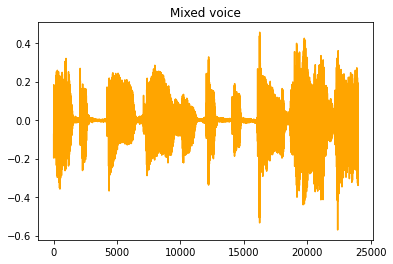

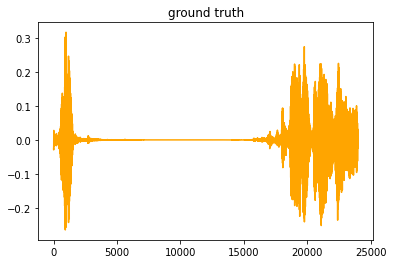

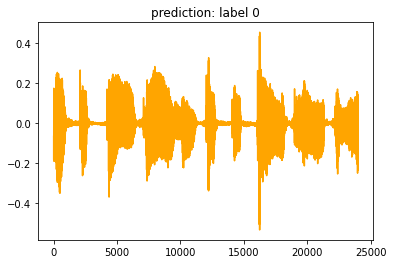

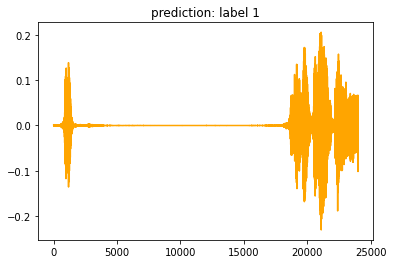

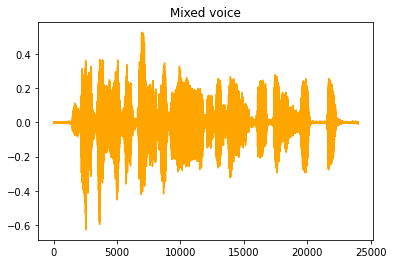

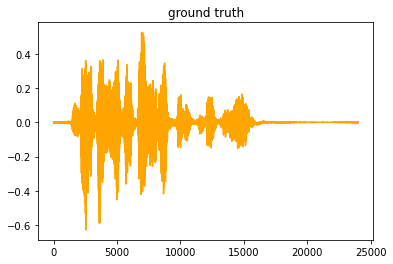

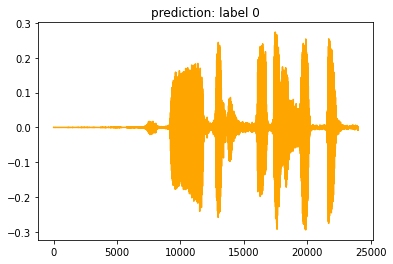

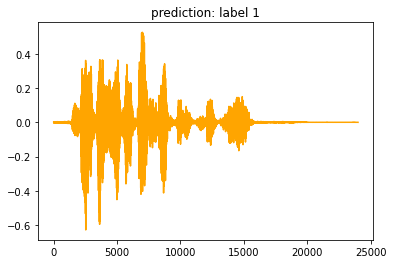

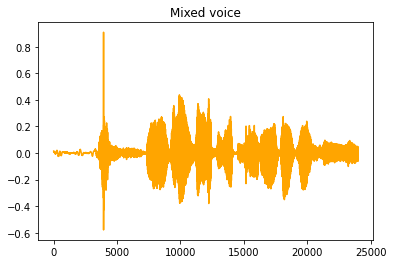

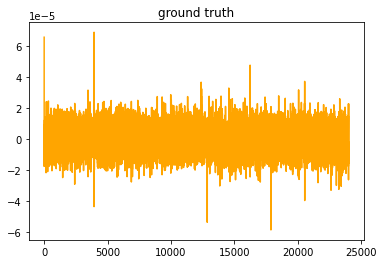

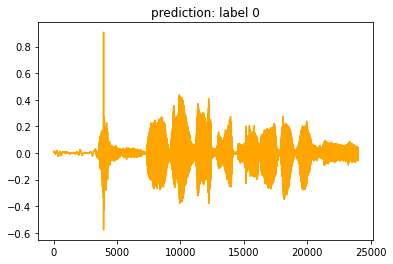

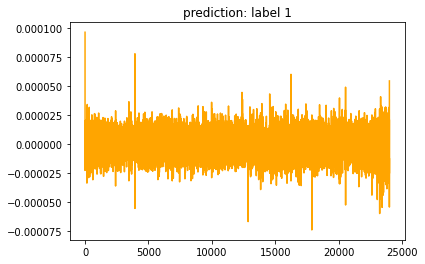

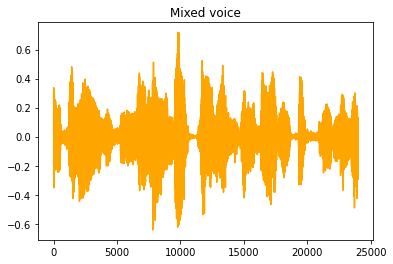

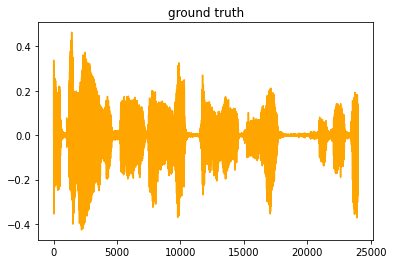

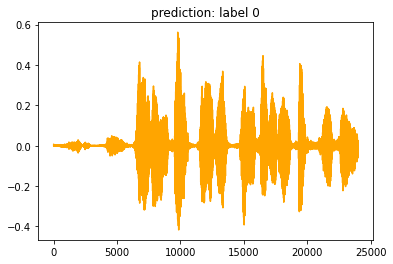

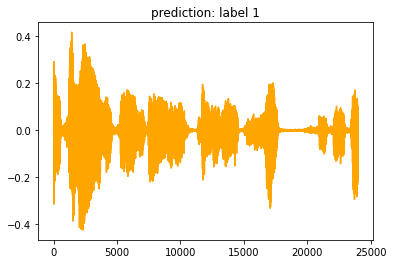

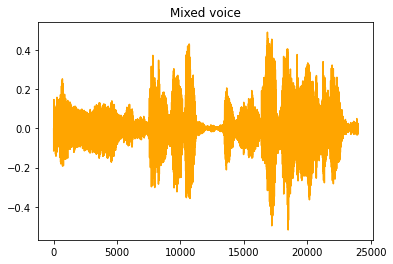

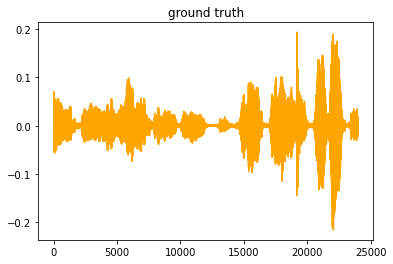

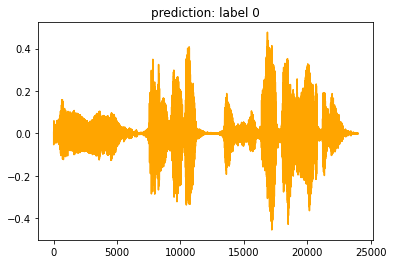

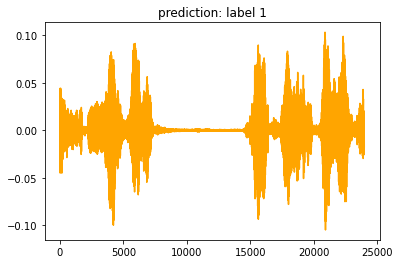

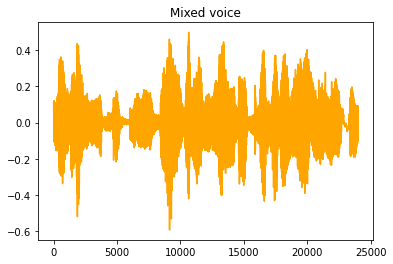

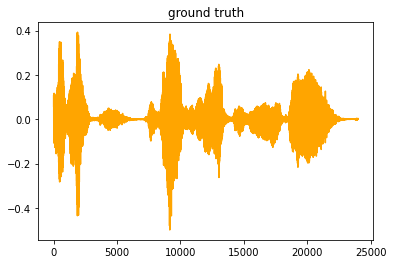

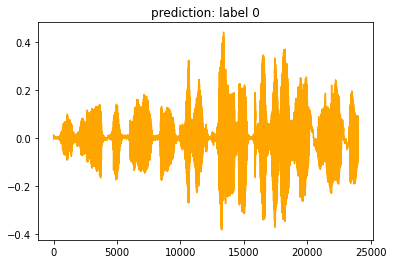

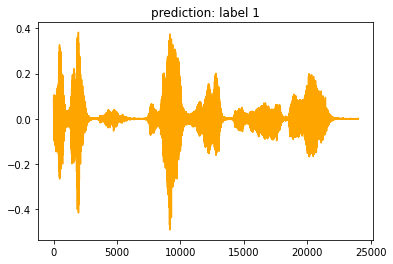

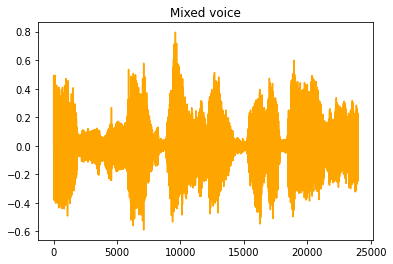

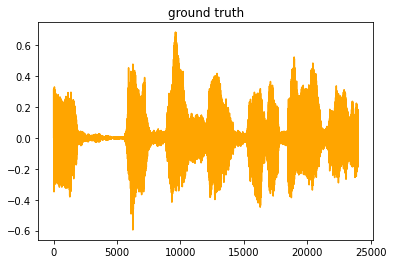

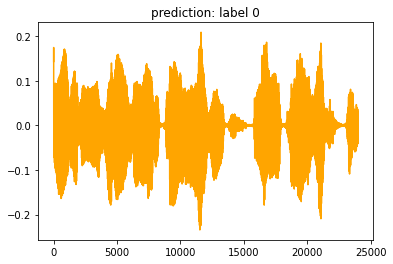

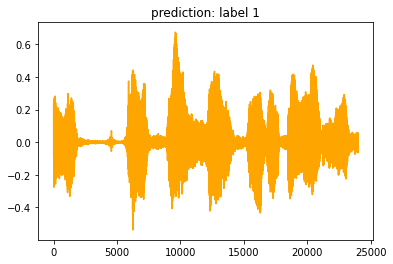

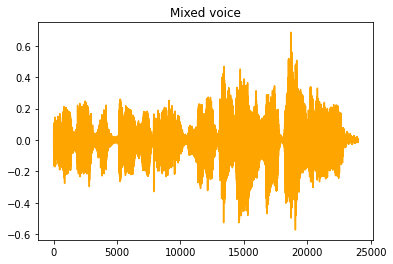

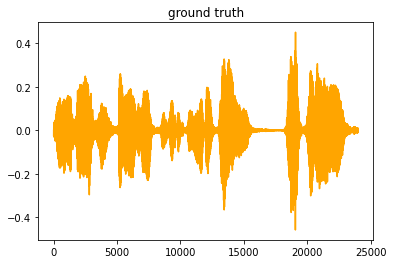

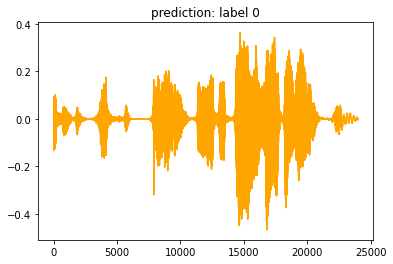

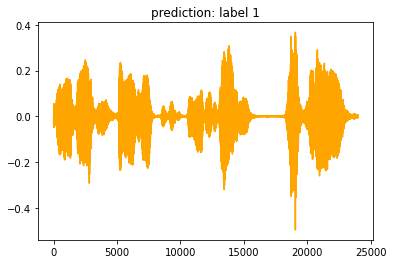

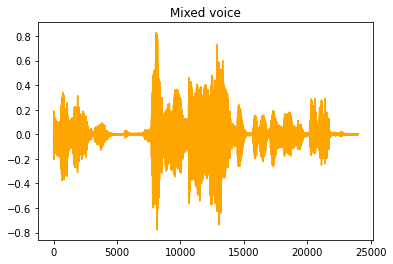

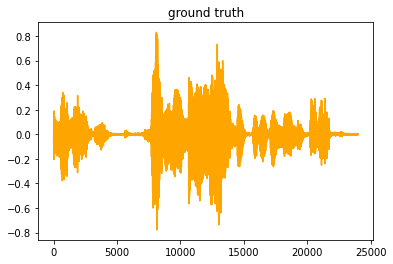

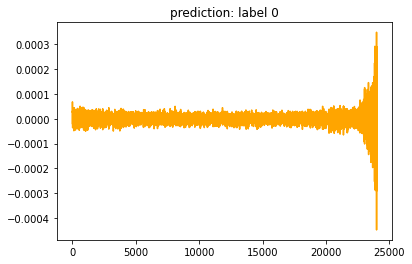

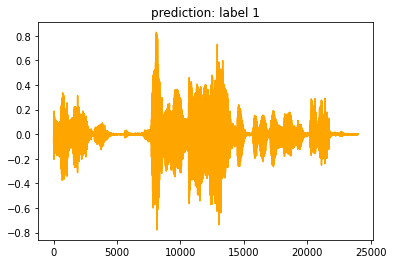

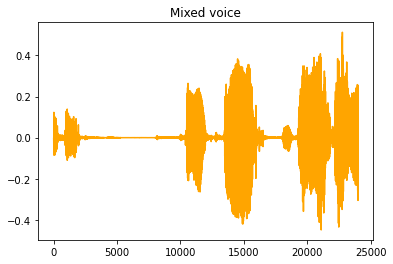

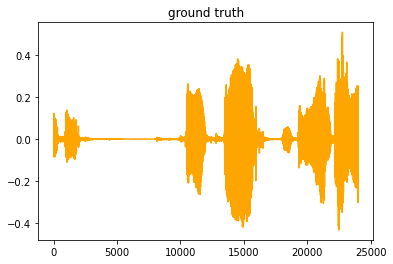

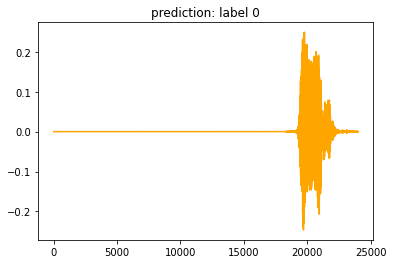

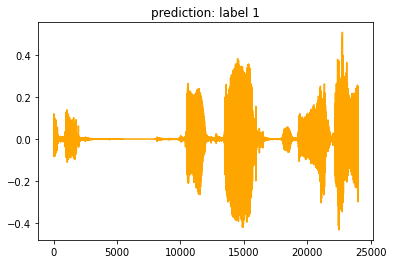

In [0]:
label_0_embeddings = np.expand_dims(embedding_matrix[0, :], axis=0)
label_1_embeddings = np.expand_dims(embedding_matrix[1, :], axis=0)

for i in range(30, 40):
  label_0_res = model.predict([np.expand_dims(X_test[i], axis=0), np.expand_dims(label_0_embeddings, axis=0)])
  label_1_res = model.predict([np.expand_dims(X_test[i], axis=0), np.expand_dims(label_1_embeddings, axis=0)])

  reconstruct_wav(X_test[i], test_phase[i], "Mixed voice")
  reconstruct_wav(y_test[i], test_phase[i], "ground truth")
  reconstruct_wav(label_0_res[0], test_phase[i], "prediction: label 0")
  reconstruct_wav(label_1_res[0], test_phase[i], "prediction: label 1")

# Try to test on real data

In [0]:
!gdown https://drive.google.com/uc?id=1pyq-4MRnSMrtb9FxL-pzuzACQhm28erC

Downloading...
From: https://drive.google.com/uc?id=1pyq-4MRnSMrtb9FxL-pzuzACQhm28erC
To: /content/bgm_free_audio.wav
57.6MB [00:00, 183MB/s]


In [0]:
!gdown https://drive.google.com/uc?id=1Ptnq7oNlGFbghEjYFKml0z4ae_T44Mo6

Downloading...
From: https://drive.google.com/uc?id=1Ptnq7oNlGFbghEjYFKml0z4ae_T44Mo6
To: /content/bgm_free_audio.npy
115MB [00:00, 125MB/s] 


In [0]:
'load data'
# data, samplerate = sf.read('bgm_free_audio.wav')
# data = load_data_array_from_npy('bgm_free_audio.npy')
data = load_data_array_from_npy(f"gdrive/My Drive/VTB_model/new_audio_apex.npy")
'Here is the pipline'
skip_length = 8000 * 94
data = data[skip_length:]

In [0]:
def data_normalization(data, ratio = 1.1):
  norm = np.max(np.abs(data)) * ratio
  # print(norm)
  # pdb.set_trace()
  data /= norm
  return data

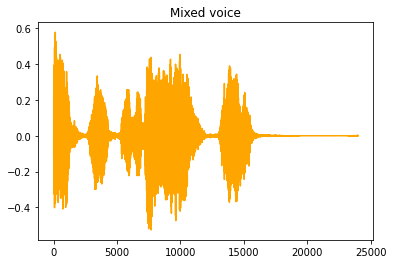

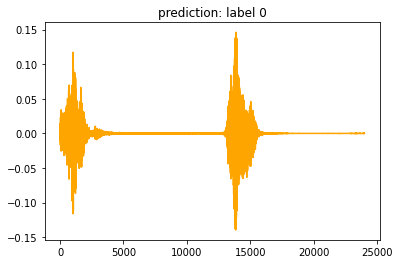

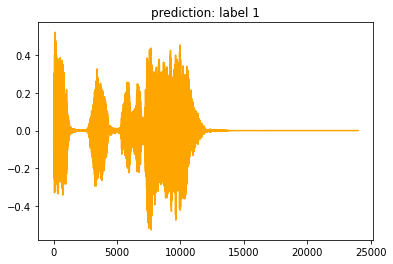

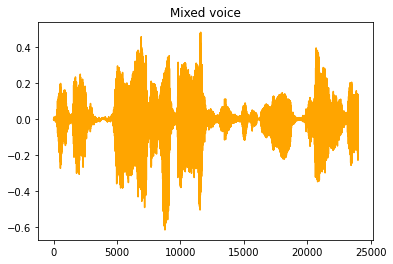

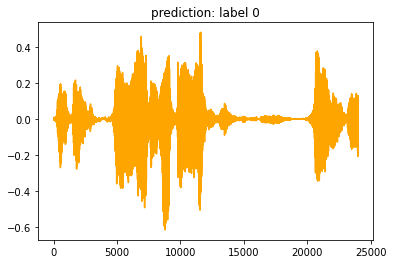

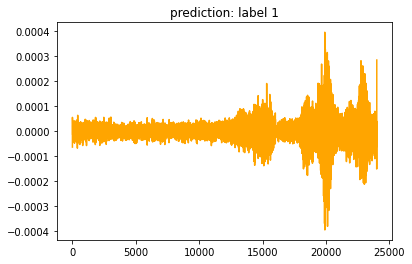

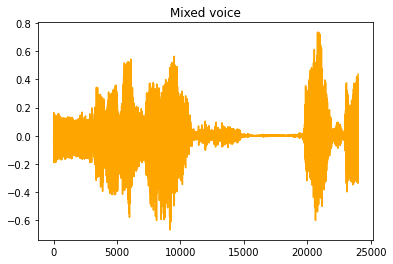

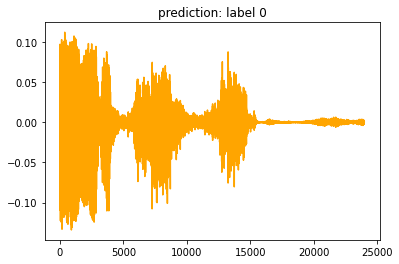

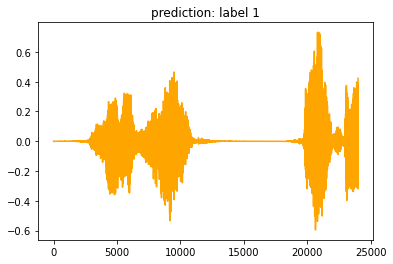

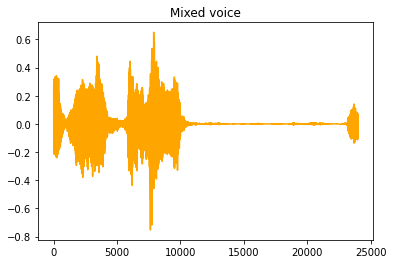

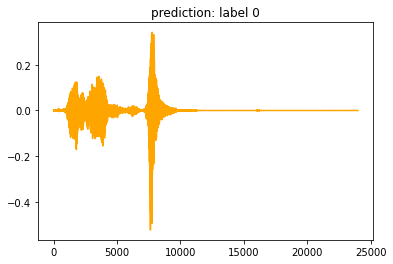

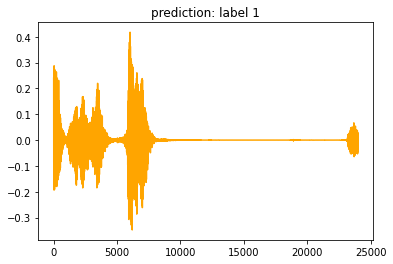

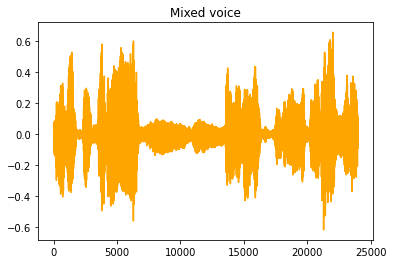

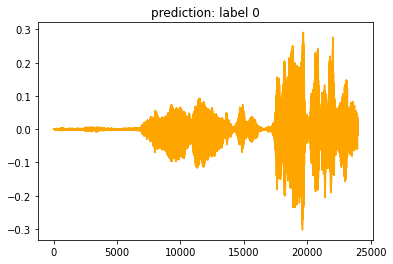

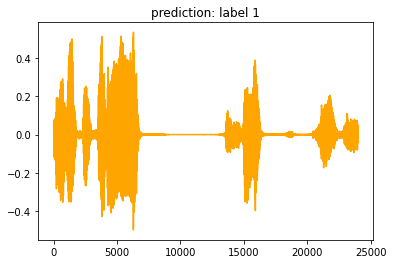

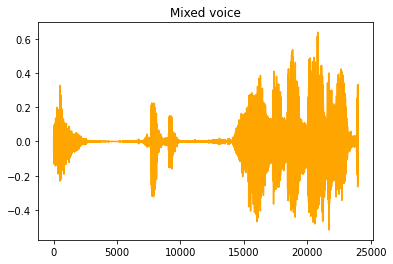

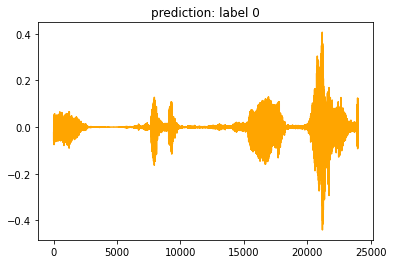

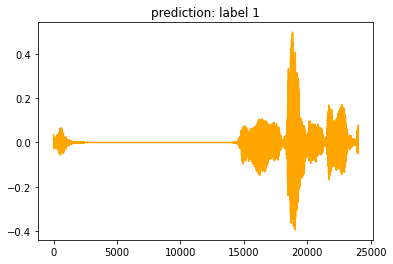

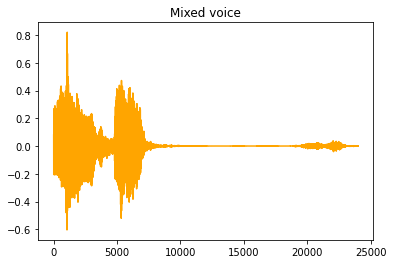

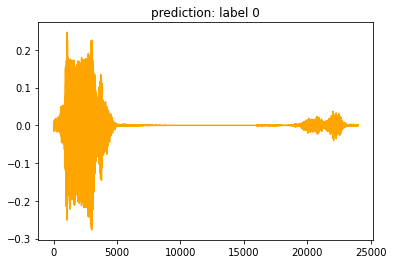

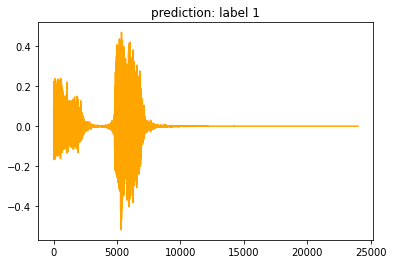

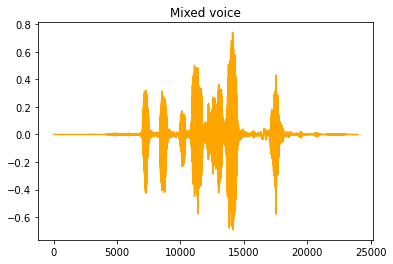

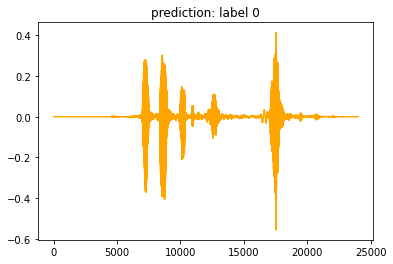

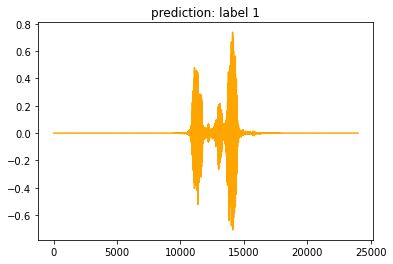

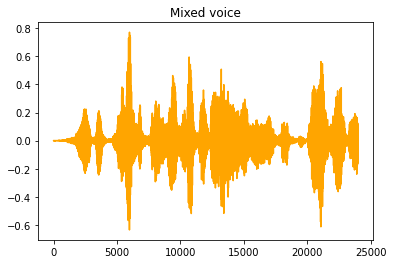

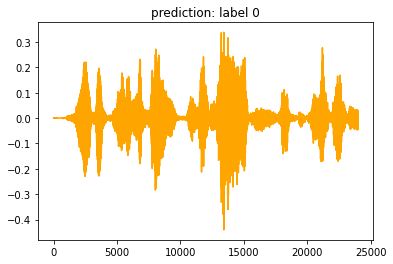

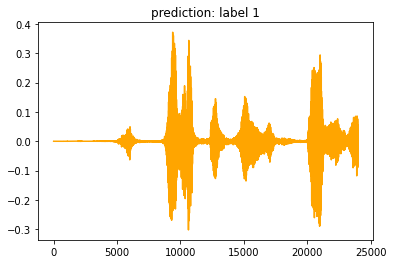

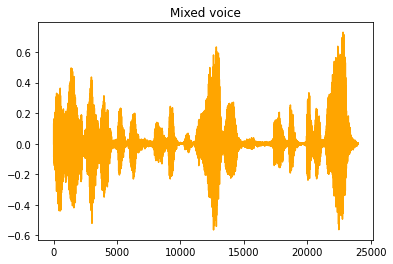

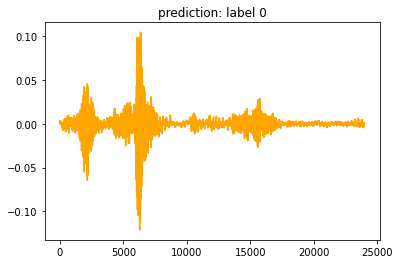

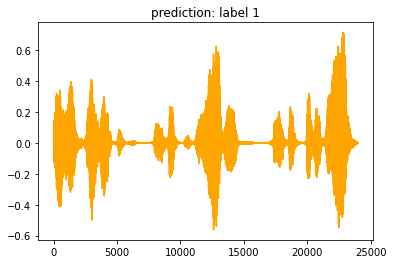

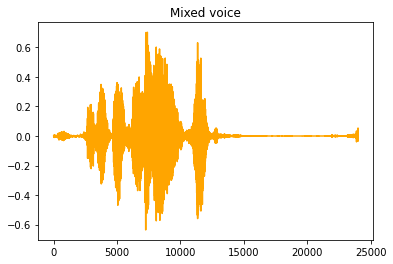

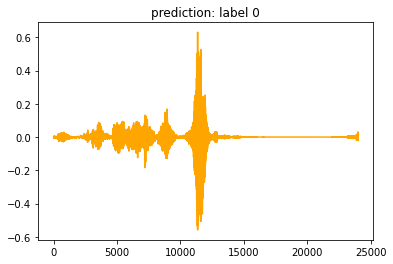

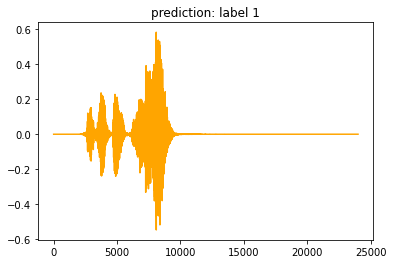

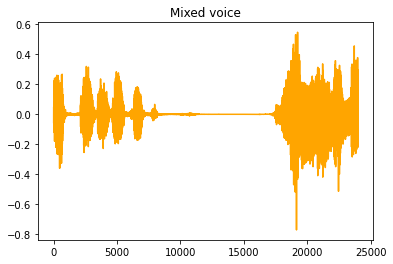

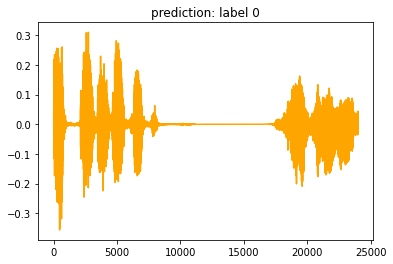

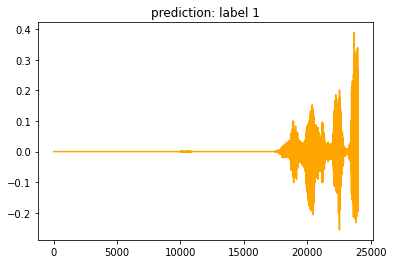

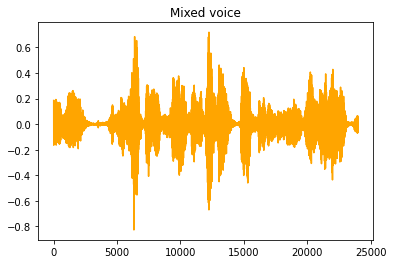

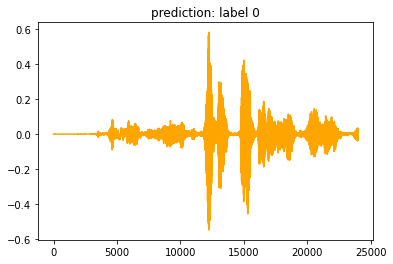

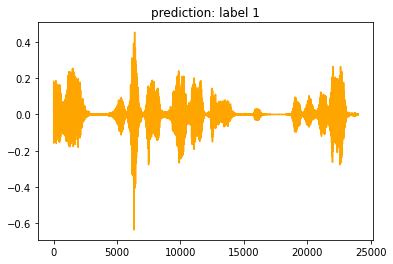

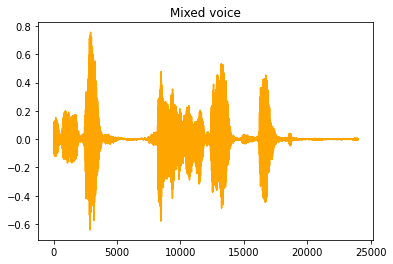

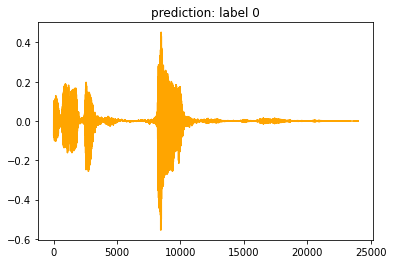

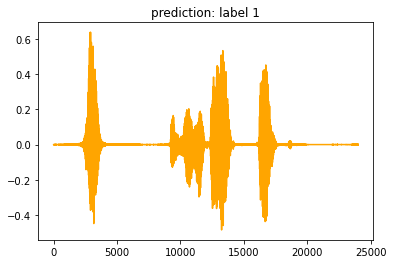

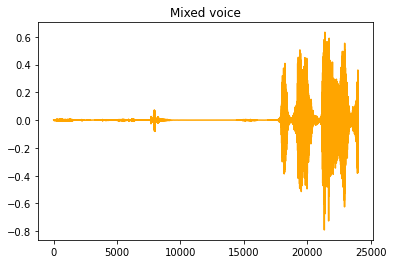

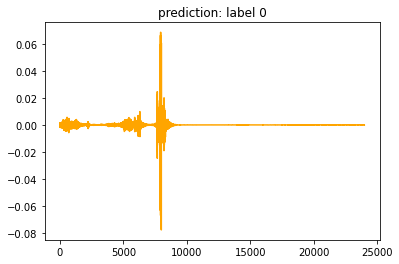

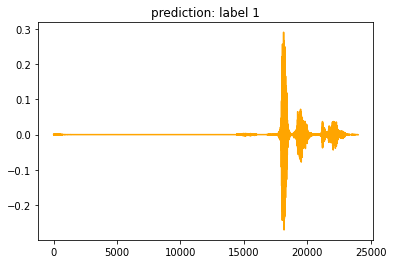

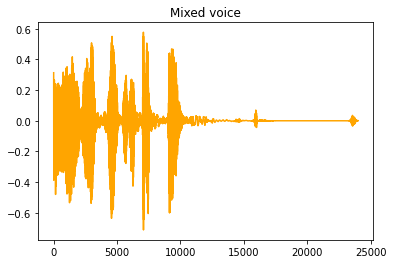

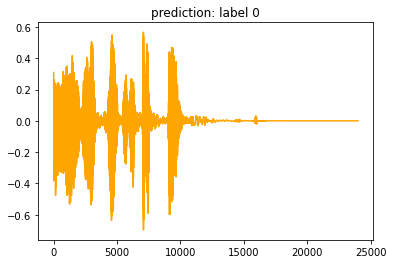

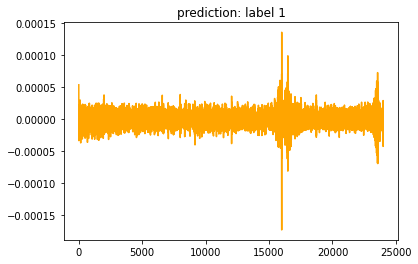

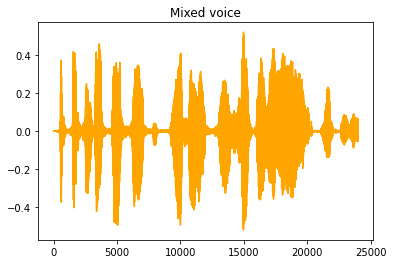

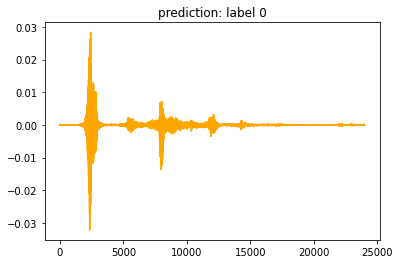

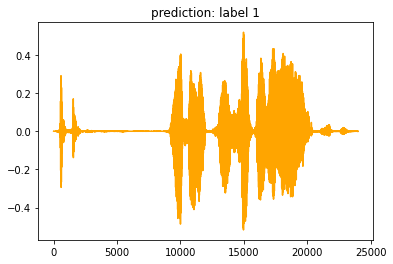

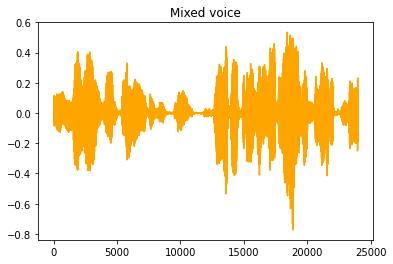

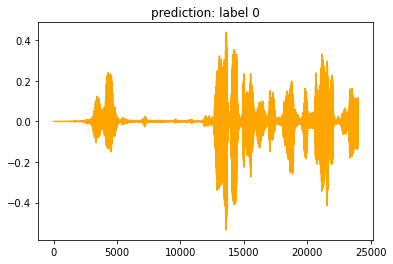

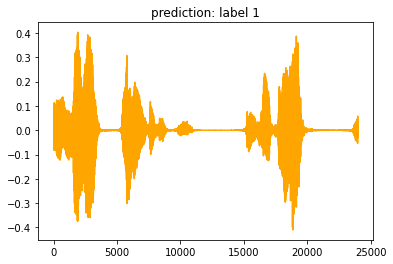

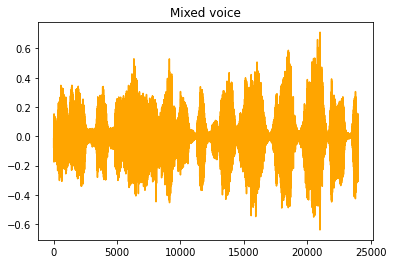

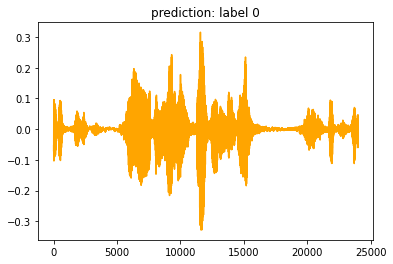

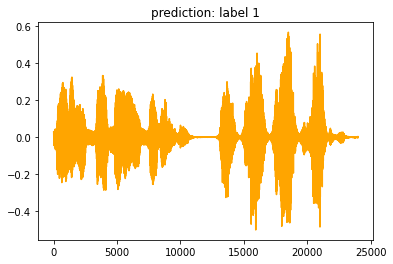

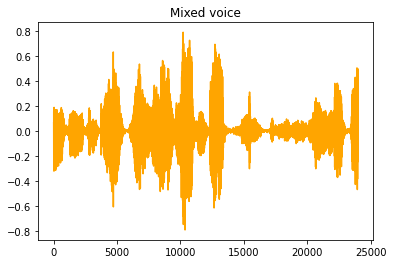

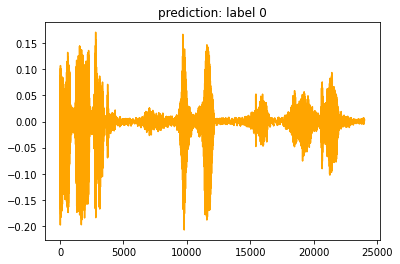

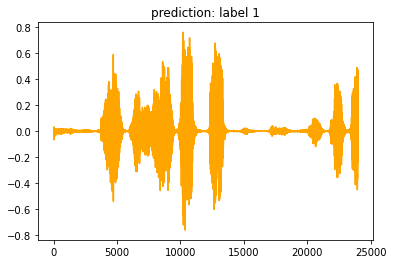

In [40]:
samplerate = 8000 * 3
total_second_number = int(len(data)//samplerate)
'iterate over the data'
splitted_res = []
for i in range(100, 120):
  start_point = i * samplerate
  end_point = (i + 1) * samplerate
  strided_data = data[start_point:end_point]
  assert len(strided_data) == samplerate
  
  strided_data = data_normalization(strided_data, ratio=1.1)
  mixed_mag, mixed_phase = audio.wav2spec(strided_data)
  
  label_0_res = model.predict([np.expand_dims(mixed_mag, axis=0), np.expand_dims(label_0_embeddings, axis=0)])
  label_1_res = model.predict([np.expand_dims(mixed_mag, axis=0), np.expand_dims(label_1_embeddings, axis=0)])

  reconstruct_wav(mixed_mag, mixed_phase, "Mixed voice")
  reconstruct_wav(label_0_res[0], mixed_phase, f"prediction: label 0")
  reconstruct_wav(label_1_res[0], mixed_phase, f"prediction: label 1")
  # 'normalize the data'
  # if i > 20:
  #   break